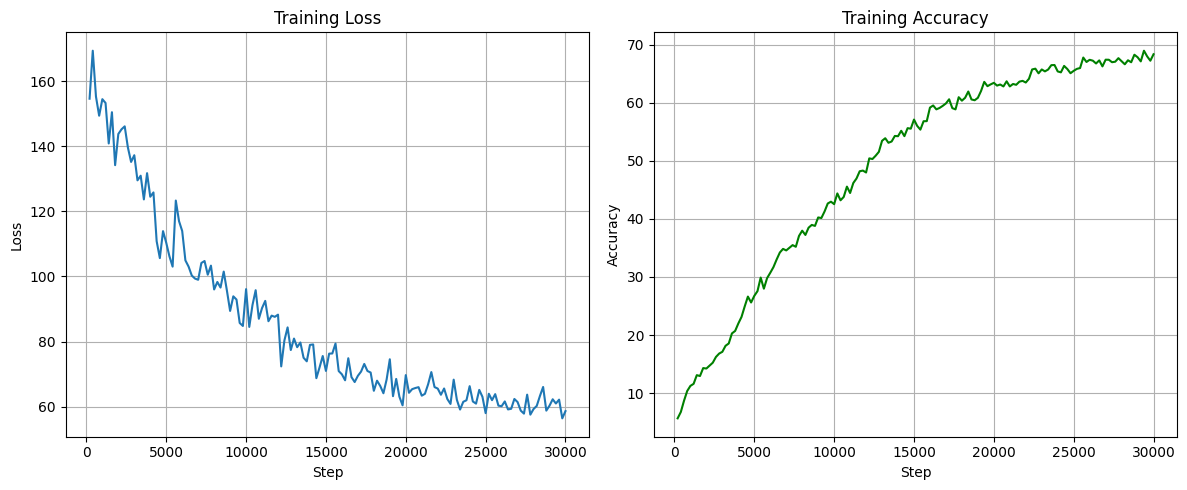

In [13]:
# 用来绘制单次训练的train或val的loss和acc曲线

from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

event_path = "exp/exp_v2t/tblog/train_inner/events.out.tfevents.1750009611.dsw-153808-7796fdfff9-kwhj5.519328.0"

loss_tag = "loss"
acc_tag = "accuracy"

ea = event_accumulator.EventAccumulator(event_path)
ea.Reload()

# 提取 loss 数据
loss_events = ea.Scalars(loss_tag)
loss_steps = [e.step for e in loss_events]
loss_values = [e.value for e in loss_events]

# 提取 acc 数据
acc_events = ea.Scalars(acc_tag)
acc_steps = [e.step for e in acc_events]
acc_values = [e.value for e in acc_events]

# 画图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_steps, loss_values, label="Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(acc_steps, acc_values, label="Accuracy", color="green")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


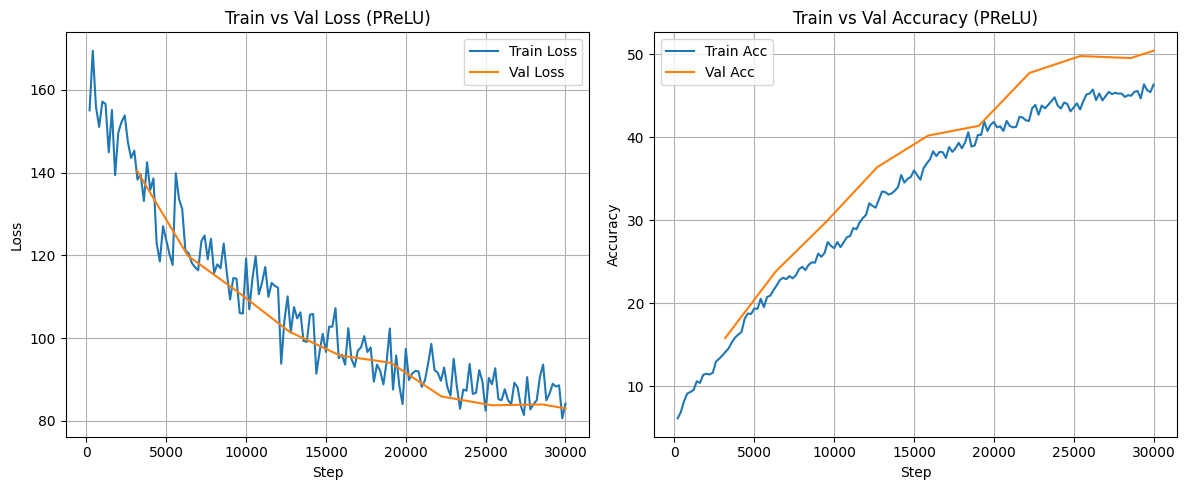

In [15]:
# 用来绘制单次训练的train和val的loss和acc曲线

from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os
import glob


log_dir = "exp/exp_v2t_relu/tblog"

loss_tag = "loss"
acc_tag = "accuracy"

def find_event_file(subdir):
    pattern = os.path.join(log_dir, subdir, "events.out.tfevents.*")
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No event file found in {subdir}")
    return files[0]

event_path_train = find_event_file("train_inner")
event_path_val = find_event_file("valid")

event_data_train = event_accumulator.EventAccumulator(event_path_train)
event_data_train.Reload()
event_data_val = event_accumulator.EventAccumulator(event_path_val)
event_data_val.Reload()

# 获取数据函数
def get_tag_data(event_data, tag):
    events = event_data.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return steps, values

# 获取每条曲线数据
train_loss_steps, train_loss_values = get_tag_data(event_data_train, loss_tag)
train_acc_steps, train_acc_values = get_tag_data(event_data_train, acc_tag)

val_loss_steps, val_loss_values = get_tag_data(event_data_val, loss_tag)
val_acc_steps, val_acc_values = get_tag_data(event_data_val, acc_tag)

# 画图
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_steps, train_loss_values, label="Train Loss")
plt.plot(val_loss_steps, val_loss_values, label="Val Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train vs Val Loss (PReLU)")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_steps, train_acc_values, label="Train Acc")
plt.plot(val_acc_steps, val_acc_values, label="Val Acc")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy (PReLU)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


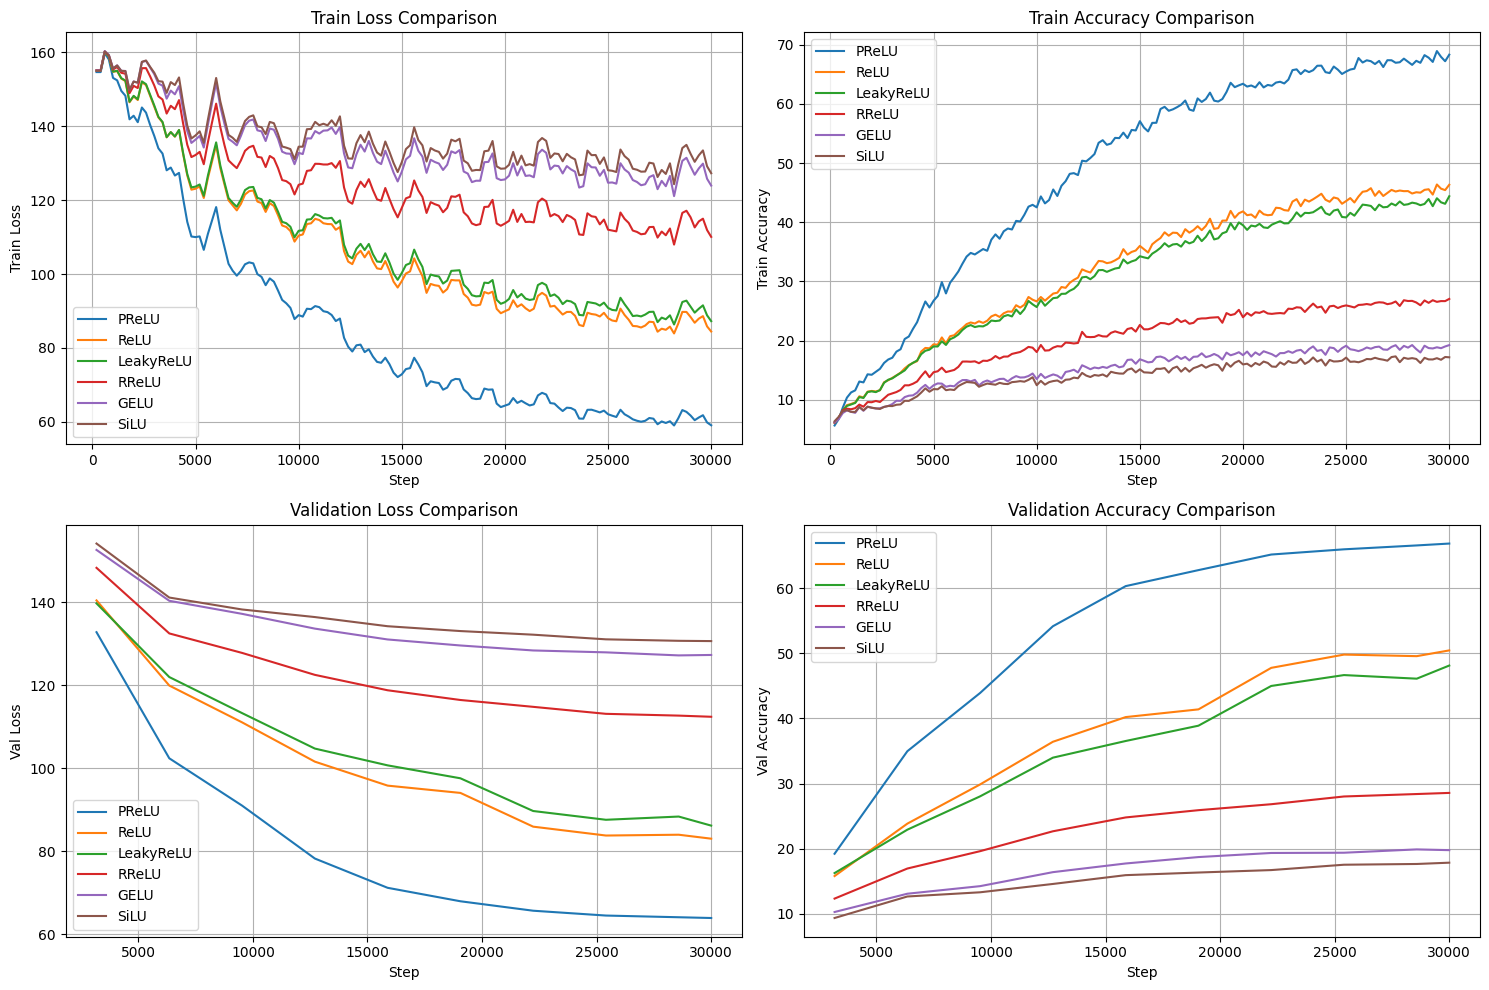

In [30]:
# 用来绘制多次训练的train和val的loss和acc曲线

from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os
import glob


log_dir_list = ["exp/exp_v2t/tblog", "exp/exp_v2t_relu/tblog", "exp/exp_v2t_leakyrelu/tblog", "exp/exp_v2t_rrelu/tblog", "exp/exp_v2t_gelu/tblog", "exp/exp_v2t_silu/tblog"]
log_name = ['PReLU', 'ReLU', 'LeakyReLU', 'RReLU', 'GELU', 'SiLU']

loss_tag = "loss"
acc_tag = "accuracy"

SMOOTH_FLAG = True
SMOOTH_WINDOW_SIZE = 3


def find_event_file(subdir, log_dir):
    pattern = os.path.join(log_dir, subdir, "events.out.tfevents.*")
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No event file found in {subdir} of {log_dir}")
    return files[0]

# 存储所有曲线数据
train_losses = []
val_losses = []
train_accs = []
val_accs = []


# 获取 tag 数据函数
def get_tag_data(event_data, tag):
    events = event_data.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return steps, values

# 对曲线进行平滑
def smooth_curve(values, window_size=5):
    import numpy as np
    if len(values) < window_size:
        return values
    smoothed = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    pad = [values[0]] * (window_size - 1)
    return pad + smoothed.tolist()


# 读取所有日志
for log_dir in log_dir_list:
    event_path_train = find_event_file("train_inner", log_dir)
    event_path_val = find_event_file("valid", log_dir)

    event_data_train = event_accumulator.EventAccumulator(event_path_train)
    event_data_train.Reload()
    event_data_val = event_accumulator.EventAccumulator(event_path_val)
    event_data_val.Reload()

    train_loss_steps, train_loss_values = get_tag_data(event_data_train, loss_tag)
    val_loss_steps, val_loss_values = get_tag_data(event_data_val, loss_tag)

    train_acc_steps, train_acc_values = get_tag_data(event_data_train, acc_tag)
    val_acc_steps, val_acc_values = get_tag_data(event_data_val, acc_tag)

    train_losses.append((train_loss_steps, train_loss_values))
    val_losses.append((val_loss_steps, val_loss_values))
    train_accs.append((train_acc_steps, train_acc_values))
    val_accs.append((val_acc_steps, val_acc_values))

# 开始画图
plt.figure(figsize=(15, 10))

# Train Loss
plt.subplot(2, 2, 1)
for i in range(len(log_dir_list)):
    steps, values = train_losses[i]
    smoothed_values = smooth_curve(values, window_size=SMOOTH_WINDOW_SIZE)
    if SMOOTH_FLAG:
        plt.plot(steps, smoothed_values, label=log_name[i])
    else:
        plt.plot(steps, values, label=log_name[i])
plt.xlabel("Step")
plt.ylabel("Train Loss")
plt.title("Train Loss Comparison")
plt.legend()
plt.grid(True)

# Train Accuracy
plt.subplot(2, 2, 2)
for i in range(len(log_dir_list)):
    steps, values = train_accs[i]
    plt.plot(steps, values, label=log_name[i])
plt.xlabel("Step")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy Comparison")
plt.legend()
plt.grid(True)

# Val Loss
plt.subplot(2, 2, 3)
for i in range(len(log_dir_list)):
    steps, values = val_losses[i]
    plt.plot(steps, values, label=log_name[i])
plt.xlabel("Step")
plt.ylabel("Val Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid(True)

# Val Accuracy
plt.subplot(2, 2, 4)
for i in range(len(log_dir_list)):
    steps, values = val_accs[i]
    plt.plot(steps, values, label=log_name[i])
plt.xlabel("Step")
plt.ylabel("Val Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()